### Imports

In [1]:
%pip install groq e2b_code_interpreter
%pip install langchain-groq

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import os
import json
import re
from groq import Groq
from e2b_code_interpreter import CodeInterpreter

### Read CSVs

In [4]:
data = pd.read_csv("data/train_titanic.csv")

In [5]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
len(data), data.dtypes

(891,
 PassengerId      int64
 Survived         int64
 Pclass           int64
 Name            object
 Sex             object
 Age            float64
 SibSp            int64
 Parch            int64
 Ticket          object
 Fare           float64
 Cabin           object
 Embarked        object
 dtype: object)

### Convert DataFrame to SQLite Database

In [7]:
from sqlite3 import connect

In [8]:
con = connect('titanic.db')
data.to_sql('Passenger Data', con, if_exists = 'replace')

891

In [9]:
from langchain_community.utilities import SQLDatabase

In [10]:
db = SQLDatabase.from_uri('sqlite:///titanic.db', sample_rows_in_table_info = 3)
db.dialect

'sqlite'

In [11]:
db.table_info

'\nCREATE TABLE "Passenger Data" (\n\t"index" INTEGER, \n\t"PassengerId" INTEGER, \n\t"Survived" INTEGER, \n\t"Pclass" INTEGER, \n\t"Name" TEXT, \n\t"Sex" TEXT, \n\t"Age" REAL, \n\t"SibSp" INTEGER, \n\t"Parch" INTEGER, \n\t"Ticket" TEXT, \n\t"Fare" REAL, \n\t"Cabin" TEXT, \n\t"Embarked" TEXT\n)\n\n/*\n3 rows from Passenger Data table:\nindex\tPassengerId\tSurvived\tPclass\tName\tSex\tAge\tSibSp\tParch\tTicket\tFare\tCabin\tEmbarked\n0\t1\t0\t3\tBraund, Mr. Owen Harris\tmale\t22.0\t1\t0\tA/5 21171\t7.25\tNone\tS\n1\t2\t1\t1\tCumings, Mrs. John Bradley (Florence Briggs Thayer)\tfemale\t38.0\t1\t0\tPC 17599\t71.2833\tC85\tC\n2\t3\t1\t3\tHeikkinen, Miss. Laina\tfemale\t26.0\t0\t0\tSTON/O2. 3101282\t7.925\tNone\tS\n*/'

### Initialize Language Model from Llama3

In [12]:
import os

In [14]:
from langchain_core.prompts import PromptTemplate

template = '''Given an input question, first create a syntactically correct {dialect} query to run. Dont Use {top_k} anywhere in the query. 
JUST RETURN THE QUERY, DON'T RETURN ANYTHING ELSE IN THE RESPONSE.
Return based on the following format:

SQL Query to run

Only use the following tables:

{table_info}.

Question: {input}'''
prompt = PromptTemplate.from_template(template)

### Generate Query Chain using Groq llama3-70b-8192

In [15]:
# TODO: Get your Groq AI API key from https://console.groq.com/
GROQ_API_KEY = ""

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = ""

# Or use 8b version
# MODEL_NAME = "llama3-8b-8192"
MODEL_NAME = "llama3-70b-8192"

In [16]:
### Retrieval Grader 
from langchain.chains import create_sql_query_chain
from langchain_community.chat_models import ChatOllama
from langchain_groq import ChatGroq

# LLM
llm = ChatGroq(model=MODEL_NAME, temperature=0, groq_api_key=GROQ_API_KEY)
generate_query = create_sql_query_chain(llm, db, prompt)                           

### Generate query based on prompt

In [17]:
query = generate_query.invoke({"question": "count of people who survived in each class"})
print(query)

SELECT Pclass, COUNT(*) as SurvivedCount 
FROM "Passenger Data" 
WHERE Survived = 1 
GROUP BY Pclass


### Get response from query (Manual Query)

In [20]:
query_cursor = con.cursor().execute(query)
cols = [column[0] for column in query_cursor.description]
query_response = query_cursor.fetchall()
pd.DataFrame.from_records(data = query_response, columns = cols)

,Pclass,SurvivedCount
0,1,136
1,2,87
2,3,119


### Query SQL Database Tool (Langchain Chain)

In [18]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
execute_query = QuerySQLDataBaseTool(db=db)

In [19]:
def modify_query(query_dict):
    original_query = query_dict.get("query", "")
    modified_query = original_query.split("SQLQuery:")[-1]
    query_dict["query"] = modified_query
    return query_dict

### Dynamic Table Selection based on Metadata

In [20]:
from operator import itemgetter
from langchain.chains.openai_tools import create_extraction_chain_pydantic
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List
import pandas as pd

def get_table_details():
    # Read the CSV file into a DataFrame
    table_description = pd.read_csv("data/database_tables.csv")
    table_docs = []

    # Iterate over the DataFrame rows to create Document objects
    table_details = ""
    for index, row in table_description.iterrows():
        table_details = table_details + "Table Name:" + row['Table'] + "\n" + "Table Description:" + row['Description'] + "\n\n"

    return table_details


class Table(BaseModel):
    """Table in SQL database."""
    name: str = Field(description="Name of table in SQL database.")

# table_names = "\n".join(db.get_usable_table_names())
table_details = get_table_details()
table_details

'Table Name:Passenger Data\nTable Description:survival\tSurvival\t0 = No, 1 = Yes\r\npclass\tTicket class\t1 = 1st, 2 = 2nd, 3 = 3rd\r\nsex\tSex\t\r\nAge\tAge in years\t\r\nsibsp\t# of siblings / spouses aboard the Titanic\t\r\nparch\t# of parents / children aboard the Titanic\t\r\nticket\tTicket number\t\r\nfare\tPassenger fare\t\r\ncabin\tCabin number\t\r\nembarked\tPort of Embarkation\tC = Cherbourg, Q = Queenstown, S = Southampton\n\n'

In [21]:
table_details_prompt = f"""Return the names of ALL the SQL tables that MIGHT be relevant to the user question. \
The tables are:

{table_details}

Remember to include ALL POTENTIALLY RELEVANT tables, even if you're not sure that they're needed."""

table_chain = create_extraction_chain_pydantic(Table, llm, system_message=table_details_prompt)
tables = table_chain.invoke({"input": "give me details of customer who travlled in 1st class"})
tables

[Table(name='Passenger Data')]

### Dynamic few-shot example selection

In [22]:
examples = [
    {
        "input": "List all passengers who survived.",
        "query": "SELECT * FROM titanic WHERE survived = 1;"
    },
    {
        "input": "Count the number of passengers who were in first class.",
        "query": "SELECT COUNT(*) FROM titanic WHERE pclass = 1;"
    },
    {
        "input": "Get the average age of passengers.",
        "query": "SELECT AVG(age) FROM titanic;"
    },
    {
        "input": "Find the name and age of the oldest passenger.",
        "query": "SELECT name, age FROM titanic ORDER BY age DESC LIMIT 1;"
    },
    {
        "input": "List all passengers who were traveling with family.",
        "query": "SELECT * FROM titanic WHERE parch > 0 OR sibsp > 0;"
    },
    {
        "input": "Count the number of male passengers.",
        "query": "SELECT COUNT(*) FROM titanic WHERE sex = 'male';"
    },
    {
        "input": "Find the passenger with the highest fare.",
        "query": "SELECT * FROM titanic ORDER BY fare DESC LIMIT 1;"
    },
    {
        "input": "List passengers who embarked from Southampton.",
        "query": "SELECT * FROM titanic WHERE embarked = 'S';"
    },
    {
        "input": "Count the number of passengers who survived from each class.",
        "query": "SELECT pclass, COUNT(*) FROM titanic WHERE survived = 1 GROUP BY pclass;"
    },
    {
        "input": "Find the average fare for passengers who survived.",
        "query": "SELECT AVG(fare) FROM titanic WHERE survived = 1;"
    },
    {
        "input": "List passengers with missing values in the 'age' column.",
        "query": "SELECT * FROM titanic WHERE age IS NULL;"
    },
    {
        "input": "Count the number of passengers with siblings or spouses aboard.",
        "query": "SELECT COUNT(*) FROM titanic WHERE sibsp > 0;"
    },
    {
        "input": "Find the name and fare of the passenger with the lowest fare.",
        "query": "SELECT name, fare FROM titanic ORDER BY fare ASC LIMIT 1;"
    },
    {
        "input": "List passengers who paid more than $100 for their ticket.",
        "query": "SELECT * FROM titanic WHERE fare > 100;"
    },
    {
        "input": "Count the number of passengers who survived with at least one parent or child aboard.",
        "query": "SELECT COUNT(*) FROM titanic WHERE survived = 1 AND (parch > 0 OR sibsp > 0);"
    },
    {
        "input": "Find the average age of passengers who did not survive.",
        "query": "SELECT AVG(age) FROM titanic WHERE survived = 0;"
    },
    {
        "input": "List passengers who paid an even fare.",
        "query": "SELECT * FROM titanic WHERE MOD(fare, 2) = 0;"
    },
    {
        "input": "Count the number of passengers who embarked from each port.",
        "query": "SELECT embarked, COUNT(*) FROM titanic GROUP BY embarked;"
    },
    {
        "input": "Find the name and age of the youngest passenger who survived.",
        "query": "SELECT name, age FROM titanic WHERE survived = 1 ORDER BY age ASC LIMIT 1;"
    },
    {
        "input": "List passengers with a cabin number starting with 'C'.",
        "query": "SELECT * FROM titanic WHERE cabin LIKE 'C%';"
    }
]


In [23]:
from langchain_community.vectorstores import Chroma
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain.embeddings import HuggingFaceEmbeddings

vectorstore = Chroma()
vectorstore.delete_collection()
example_selector = SemanticSimilarityExampleSelector.from_examples(
     examples,
     HuggingFaceEmbeddings(),
     vectorstore,
     k=2,
     input_keys=["input"],
 )

In [24]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

example_prompt = ChatPromptTemplate.from_messages(
     [
         ("human", "{input}\nSQLQuery:"),
         ("ai", "{query}"),
     ]
 )

few_shot_prompt = FewShotChatMessagePromptTemplate(
     example_prompt=example_prompt,
     example_selector=example_selector,
     input_variables=["input","top_k"],
 )

In [25]:
final_prompt = ChatPromptTemplate.from_messages(
     [
         ("system", "You are a MySQL expert. Given an input question, create a syntactically correct MySQL query to run. Unless otherwise specificed.\n\nHere is the relevant table info: {table_info}\n\nBelow are a number of examples of questions and their corresponding SQL queries."),
         few_shot_prompt,
         ("human", "{input}"),
     ]
 )

In [26]:
final_prompt.format(input="How many people who travelled in 1st class did not survive?", table_info=tables)

"System: You are a MySQL expert. Given an input question, create a syntactically correct MySQL query to run. Unless otherwise specificed.\n\nHere is the relevant table info: [Table(name='Passenger Data')]\n\nBelow are a number of examples of questions and their corresponding SQL queries.\nHuman: List all passengers who survived.\nSQLQuery:\nAI: SELECT * FROM titanic WHERE survived = 1;\nHuman: Count the number of passengers who were in first class.\nSQLQuery:\nAI: SELECT COUNT(*) FROM titanic WHERE pclass = 1;\nHuman: How many people who travelled in 1st class did not survive?"

In [27]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

answer_prompt = PromptTemplate.from_template(
 """Given the following user question, corresponding SQL query, and SQL result, answer the user question.

Question: {question}
SQL Query: {query}
SQL Result: {result}
Answer: """
)

rephrase_answer = answer_prompt | llm | StrOutputParser()

chain = (
 RunnablePassthrough.assign(query=create_sql_query_chain(llm, db))
    .assign(query=modify_query)
    .assign(result=itemgetter("query") | execute_query) | rephrase_answer
)

chain.invoke({"question": "How many people who travelled in 1st class did not survive?"})

'80'

### Initialize tools for function calling

In [27]:
SYSTEM_PROMPT = """you are a python data scientist. you are given tasks to complete and you run python code to solve them.
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment"""


tools = [
  {
    "type": "function",
      "function": {
        "name": "execute_python",
        "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
        "parameters": {
          "type": "object",
          "properties": {
            "code": {
              "type": "string",
              "description": "The python code to execute in a single cell.",
            }
          },
          "required": ["code"],
        },
      },
  }
]

In [26]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [25]:
client = Groq(api_key=GROQ_API_KEY)

def chat_with_llama(e2b_code_interpreter, user_message):
  print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_message}
  ]

  response = client.chat.completions.create(
      model=MODEL_NAME,
      messages=messages,
      tools=tools,
      tool_choice="auto",
      max_tokens=4096,
  )

  print(response)

  response_message = response.choices[0].message
  tool_calls = response_message.tool_calls

  if tool_calls:
    for tool_call in tool_calls:
      function_name = tool_call.function.name
      function_args = json.loads(tool_call.function.arguments)
      if function_name == "execute_python":
        code = function_args["code"]
        code_interpreter_results = code_interpret(e2b_code_interpreter, code)
        return code_interpreter_results
      else:
        raise Exception(f"Unknown tool {function_name}")
  else:
    print(f"(No tool call in model's response) {response_message}")
    return []


User message: Generate a visualization based on the SQL Query 'SELECT Pclass, COUNT(*) as SurvivedCount 
FROM "Passenger Data" 
WHERE Survived = 1 
GROUP BY Pclass', the returned dataset '[(1, 136), (2, 87), (3, 119)]', and columns '['Pclass', 'SurvivedCount']'. Request a pie_chart to represent the data appropriately.
ChatCompletion(id='chatcmpl-7f711a8c-d7cc-42c4-b80a-b73bc59a7f5d', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_7c2r', function=Function(arguments='{"code":"import matplotlib.pyplot as plt\\nimport numpy as np\\n\\n# Dataset\\nPclass = [1, 2, 3]\\nSurvivedCount = [136, 87, 119]\\n\\n# Create pie chart\\nplt.pie(SurvivedCount, labels=Pclass, autopct=\'%1.1f%%\')\\nplt.title(\'Survival Count by Pclass\')\\nplt.show()"}', name='execute_python'), type='function')]))], created=1717894028, model='llama3-70b-8192', object='c

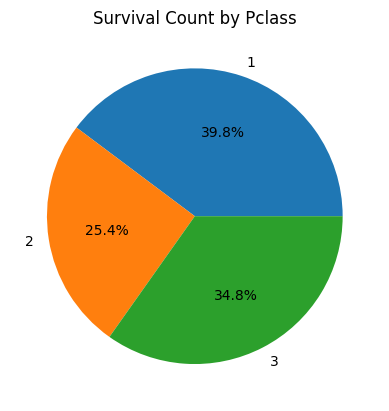

In [31]:
visualization_function = "pie_chart"
prompt =  f"Generate a visualization based on the SQL Query '{query}', the returned dataset '{query_response}', and columns '{cols}'. Request a {visualization_function} to represent the data appropriately."

with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
    code_results = chat_with_llama(
        code_interpreter,
        prompt
    )
    if code_results:
        print(code_results)
        first_result = code_results[0]
    else:
        print("No code results")
        exit(0)

# This will render the image
# You can also access the data directly
# first_result.png
# first_result.jpg
# first_result.pdf
# ...
first_result